# Analysis of the Skytrax Review Dataset

## Import Startements

In [1]:
# import standard data analysis python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Global options and color definition

In [2]:
# set number of rows to display for a pandas dataframe
pd.set_option('display.max_rows', 20)

# seaborn default style
sns.set_theme(style="darkgrid")

pos = '#FF7518' # pumpkin orange
neg = '#18A2FF' # complementary color

# Corporate colors for airlines from https://www.schemecolor.com/

# LH Group
lufthansaBlue = '#00235F'
swissRed = '#E60005'
austrianBlue = 'lightskyblue' #'#e71c23'

# Five-Star airlines
siaOrange = '#fcb130'
cathayGreen = '#00645a'
qatarGrey = '#747f8a'
garudaBlue = '#002561'

# US legacy carrier
unitedBlue = '#005daa'
americanGray = '#C7CFD7'
deltaBlue = '#003268'
deltaRed = '#9b1631'

# large european airlines
klmBlue = '#00a1e4'
afRed = '#002157'
britishBlue = '#0035AD'

# create color palettes for each airline group

groupPalette = {'lufthansa' : lufthansaBlue, 'swiss' : swissRed, 'austrian' : austrianBlue}

fiveStarPalette = {'swiss' : swissRed, 'singapore' : siaOrange,
                   'cathay' : cathayGreen, 'qatar' : qatarGrey, 'garuda' : garudaBlue}

legacyPalette = {'swiss' : swissRed, 'american' : americanGray, 'united' : unitedBlue, 'delta' : deltaBlue}

europePalette = {'swiss' : swissRed, 'airfrance' : afRed, 'klm' : klmBlue, 'british' : britishBlue}

In [3]:
# Import dataset 
data = pd.read_csv('./data/airline.csv')

# this dictionary stores the content variable for all airlines. Gets filled during data cleaning and might be useful
contentData = {}

## Data loading and data cleaning functions

In [4]:
def get_airline_data(name):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    name : string
        Airline name

    Returns
    -------
    airlineData : DataFrame
            Pandas DataFrame that contains data of selected airline
    """
    # use global data variable (if exists) to avoid repetitive loading of dataset
    global data
    global contentData
    
    if data is None:
        data = pd.read_csv('./data/airline.csv')
    
    airlineData = data[data["airline_name"] == name]
    airlineData = airlineData.reset_index(drop=True)
    
    contentData[name] = airlineData['content']
    
    print(f"Dataset for {name.upper()} contains {len(airlineData)} data points")
    
    return airlineData

In [5]:
def get_missing_data(airlineGroup):
    """ prints out all columns that have NaN values
    
    Parameters
    ----------
    airlineGroup : DataFrame
        Airline group data
    """
    
    for airlineName, airlineData in airlineGroup.items():
        print(f'{airlineName.upper()} - {len(airlineData)} reviews\n')
        #get_missing_data(value)


        # flag to indicate whether missing values were found
        missingValues = False

        # iterate through all columns and count number of missing values
        for col in airlineData.columns:
            numberMissing = airlineData[col].isna().sum()
            missPercentage = np.around(numberMissing/len(airlineData)*100, decimals=1)
            if numberMissing > 0 :
                missingValues = True
                print(f'{col.upper()} : ({numberMissing}/{len(airlineData)}) missing values ({missPercentage}%) ')

        if not missingValues:
            print("No NaN values left!")

        print("\n")

In [6]:
def clean_metadata(airlineGroup):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    airlineGroup : dict
        Airline group data. Contains DataFrame for each airline in group

    Returns
    -------
    cleanedData : DataFrame
        data without the columns that contain metadata
    """
    
    cleanedAirlineGroup = {}
    
    for airlineName, airlineData in airlineGroup.items():
        
        cleanedAirline = airlineData
        
        # rename labels for First and Business Class
        cleanedAirline.replace(to_replace={'cabin_flown' : 'Business Class'}, value='Business', inplace=True)
        cleanedAirline.replace(to_replace={'cabin_flown' : 'First Class'}, value='First', inplace=True)
        
        # rename Airline column
        cleanedAirline.rename(columns={'airline_name' : 'airline'}, inplace=True)
        
        # change airline name to more intuitive version (e.g. swiss-international-air-lines to swiss )
        oldName = airlineData['airline'].unique()[0]
        newName = airlineName
        
        cleanedAirline.replace(to_replace={'airline' : oldName}, value=newName, inplace=True)
        
        # drop metadata columns
        cleanedAirline = cleanedAirline.drop(columns={"link", "author", "author_country", "title", 
                                         "aircraft", "route", "content", "type_traveller"})
        
        cleanedAirlineGroup[airlineName] = cleanedAirline
        
    return cleanedAirlineGroup

In [7]:
def remove_nan(airlineGroup, threshold=0):
    """ data loader function to get data for a selected airline
    
    Parameters
    ----------
    airlineGroup : dict
        Airline group data. Contains DataFrame for each airline in group
    
    threshold : int
        If the number of NaN values in a column is below this threshold, the respective rows are dropped
        to remove the NaN values
    
    Returns
    -------
    cleanedData : DataFrame
        data cleaned from NaN values 
    """
    
    nanFreeAirlineGroup = {}
    
    for airlineName, airlineData in airlineGroup.items():
        
        nanFreeAirline = airlineData
        
        nanFreeAirline = nanFreeAirline.drop(columns={"wifi_connectivity_rating", "ground_service_rating"})

        # replace value for inflight entertainemnt with mean
        nanFreeAirline['inflight_entertainment_rating'].fillna(
        value=np.around(nanFreeAirline['inflight_entertainment_rating'].mean()), inplace=True)

        # replace value for missing overall rating by mean of all other ratings
        ratingNaNIndex = nanFreeAirline[nanFreeAirline['overall_rating'].isna()==True].index

        for index in ratingNaNIndex:
            replaceValue = nanFreeAirline[['seat_comfort_rating','cabin_staff_rating','food_beverages_rating',
                                  'inflight_entertainment_rating','value_money_rating']].iloc[index].mean()
            nanFreeAirline.loc[index,'overall_rating'] = max(np.around(replaceValue),1)

        # drop NaN below 
        for col in nanFreeAirline.columns:
            numberMissing = nanFreeAirline[col].isna().sum()
            #print(f"{col} : {numberMissing} values")

            if numberMissing <= threshold:
                nanFreeAirline = nanFreeAirline[nanFreeAirline[col].notna()]
        
        nanFreeAirlineGroup[airlineName] = nanFreeAirline
            
    return nanFreeAirlineGroup  

# Data Analysis

This Jupyter notebook contains an analysis of the Skytrax customer review dataset (Link: https://github.com/quankiquanki/skytrax-reviews-dataset). The main focus is to investigate the customer reviews of SWISS International Airlines and compare them to other airlines. 

# Analysiere Kundenbewertungen der Swiss im Zeitraum von 2012 bis 2015

In den Jahren 2012 - 2015 betrug die jährliche Zahl der Fluggäste etwa  17 Mio. (Quelle: https://de.statista.com/statistik/daten/studie/291651/umfrage/fluggaeste-von-swiss/)

## Load data

In [8]:
# get data for LH-Group airlines

swiss = get_airline_data("swiss-international-air-lines")
lufthansa = get_airline_data("lufthansa")
austrian = get_airline_data("austrian-airlines")

# get data for all Airlines that were rated with 5 Stars in 2015 by Skytrax
# source: https://en.wikipedia.org/wiki/Skytrax#Airline_rankings
    
sia = get_airline_data("singapore-airlines")
ana = get_airline_data("ana-all-nippon-airways")
qatar = get_airline_data("qatar-airways")
cathay = get_airline_data("cathay-pacific-airways")
asiana = get_airline_data("asiana-airlines")
eva = get_airline_data("eva-air")
garuda = get_airline_data("garuda-indonesia")
hainan = get_airline_data("hainan-airlines")
jal = get_airline_data("japan-airlines")
korean = get_airline_data("korean-air")

# get data for US legacy carriers 
american = get_airline_data("american-airlines")
united = get_airline_data("united-airlines")
delta = get_airline_data("delta-air-lines")

# get data for other major european airlines
airfrance = get_airline_data("air-france")
british = get_airline_data("british-airways")
klm = get_airline_data("klm-royal-dutch-airlines")

# store all airline dataset into dictionary
lhGroup = {'swiss' : swiss, 'lufthansa': lufthansa, 'austrian' : austrian}

fiveStar = {'sia' : sia, 'ana' : ana, 'qatar' : qatar, 'cathay' : cathay, 'asiana' : asiana,
            'eva' : eva, 'garuda' : garuda, 'hainan' : hainan, 'jal' : jal, 'korean' : korean}

legacyCarrier = {'united' : united, 'delta' : delta, 'american' : american}

european = {'airfrance' : airfrance, 'british' : british, 'klm' : klm}

Dataset for SWISS-INTERNATIONAL-AIR-LINES contains 336 data points
Dataset for LUFTHANSA contains 600 data points
Dataset for AUSTRIAN-AIRLINES contains 281 data points
Dataset for SINGAPORE-AIRLINES contains 432 data points
Dataset for ANA-ALL-NIPPON-AIRWAYS contains 273 data points
Dataset for QATAR-AIRWAYS contains 492 data points
Dataset for CATHAY-PACIFIC-AIRWAYS contains 494 data points
Dataset for ASIANA-AIRLINES contains 303 data points
Dataset for EVA-AIR contains 302 data points
Dataset for GARUDA-INDONESIA contains 352 data points
Dataset for HAINAN-AIRLINES contains 88 data points
Dataset for JAPAN-AIRLINES contains 171 data points
Dataset for KOREAN-AIR contains 322 data points
Dataset for AMERICAN-AIRLINES contains 612 data points
Dataset for UNITED-AIRLINES contains 840 data points
Dataset for DELTA-AIR-LINES contains 466 data points
Dataset for AIR-FRANCE contains 398 data points
Dataset for BRITISH-AIRWAYS contains 901 data points
Dataset for KLM-ROYAL-DUTCH-AIRLINES c

## Preprocessing

### Remove unnecessary data

Zuerst werden alle Spalten entfernt, die keinen (unmittelbaren) Einfluss auf die Bewertung des Fluggastes haben (Metadaten) und auch nicht zur Indizierung benötigt werden:
* **link**: Link zur Datenquelle (irrelevant) -> **drop**
* **author & author_country**: Name und Herkunft des Autors (irrelevant) -> **drop**
* **airline_name**: Für alle Datenpunkte gleich, da nur Swiss betrachtet wird -> **drop**  **Überprüfen**
* **title**: Auch für alle Datenpunkte gleich -> **drop** 

Folgende Variablen können einen Einfluss auf die Zufriedenheit der Kunden haben 
* **aircraft**: Leider nur für 14 der 336 Datenpunkte erfasst, der Flugzeugtyp kann aber prinzipiell die Kundenzufriedenheit beeinflussen (Beispiel A380 wird von Fluggästen sehr positiv wahrgenommen) -> Flugzeugtyp könnte aber aus anderen Datenquellen ergänzt werden, wenn Flugnummer und/oder Flugsegmente bekannt sind (FlighRadar24, interne Datenbank) -> hier aber **drop**
* **route**: Auch hier nur vereinzelt Daten vorhanden, viele Passagiere bewerten ihre gesamte Reise, die oft auch aus mehreren Flugsegmenten besteht. Route könnte bei Bedarf teilweise aus **content** abgeleitet werden. Für diesen vereinfachten Fall wird das gesamte Reiseerlebnis mit Swiss betrachtet, unabhängig von Route und möglichen Umstiegen -> **drop**
* **content**: Geschriebene Bewertung der Nutzer und ist für alle Datenpunkte vorhanden. Enthält sehr viele Infos zu Route, Aircraft und allgemeinenen Zufriedenheit, die durch Natural Language Processing (NLP) extrahiert werden könnten. **Sehr wertvolle Daten, bei denen sich grundsätzlich eine weiterführende Analyse anbietet** -> werden in der Variable **contentData** abgespeichert 
* **type traveller**: Geschäftsreisende haben andere (oft höhere) Ansprüche an das Produkt, als Privatreisende. Allerdings sind auch hier nur unzureichende Daten vorhanden -> **drop**

Somit bleiben folgende Variablen übrig, die einen direkten Einfluss auf die Kundenzufriedenheit haben:
* **cabin_flown**
* **overall_rating**
* **seat_comfort_rating**
* **cabin_staff_rating**
* **food_beverages_rating**
* **inflight_entertainment_rating**
* **ground_service_rating**
* **wifi_connectivity_rating**
* **value_money_rating**
* **recommended**

sowie folgende Metadaten:
* **date**
* **airline**

In [9]:
# clean metadata for each airline group (works inplace, repeated execution of cell will fail)
lhGroup = clean_metadata(lhGroup)
fiveStar = clean_metadata(fiveStar)
legacyCarrier = clean_metadata(legacyCarrier)
european = clean_metadata(european)

### Missing data
Im nächsten Schritt wird ermittelt, wie viele fehlende Werte es pro Merkmal gibt und danach eine Strategie entwickelt diese zu ersetzen

In [10]:
# missing data for LH-Group
get_missing_data(lhGroup)

SWISS - 336 reviews

OVERALL_RATING : (18/336) missing values (5.4%) 
INFLIGHT_ENTERTAINMENT_RATING : (3/336) missing values (0.9%) 
GROUND_SERVICE_RATING : (321/336) missing values (95.5%) 
WIFI_CONNECTIVITY_RATING : (333/336) missing values (99.1%) 


LUFTHANSA - 600 reviews

INFLIGHT_ENTERTAINMENT_RATING : (13/600) missing values (2.2%) 
GROUND_SERVICE_RATING : (550/600) missing values (91.7%) 
WIFI_CONNECTIVITY_RATING : (584/600) missing values (97.3%) 


AUSTRIAN - 281 reviews

OVERALL_RATING : (18/281) missing values (6.4%) 
FOOD_BEVERAGES_RATING : (4/281) missing values (1.4%) 
INFLIGHT_ENTERTAINMENT_RATING : (10/281) missing values (3.6%) 
GROUND_SERVICE_RATING : (263/281) missing values (93.6%) 
WIFI_CONNECTIVITY_RATING : (281/281) missing values (100.0%) 




In [11]:
# missing data for 5-Star airlines
get_missing_data(fiveStar)

SIA - 432 reviews

GROUND_SERVICE_RATING : (409/432) missing values (94.7%) 
WIFI_CONNECTIVITY_RATING : (423/432) missing values (97.9%) 


ANA - 273 reviews

OVERALL_RATING : (6/273) missing values (2.2%) 
SEAT_COMFORT_RATING : (99/273) missing values (36.3%) 
CABIN_STAFF_RATING : (99/273) missing values (36.3%) 
FOOD_BEVERAGES_RATING : (99/273) missing values (36.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (100/273) missing values (36.6%) 
GROUND_SERVICE_RATING : (262/273) missing values (96.0%) 
WIFI_CONNECTIVITY_RATING : (270/273) missing values (98.9%) 


QATAR - 492 reviews

INFLIGHT_ENTERTAINMENT_RATING : (1/492) missing values (0.2%) 
GROUND_SERVICE_RATING : (443/492) missing values (90.0%) 
WIFI_CONNECTIVITY_RATING : (479/492) missing values (97.4%) 


CATHAY - 494 reviews

CABIN_FLOWN : (1/494) missing values (0.2%) 
FOOD_BEVERAGES_RATING : (1/494) missing values (0.2%) 
INFLIGHT_ENTERTAINMENT_RATING : (1/494) missing values (0.2%) 
GROUND_SERVICE_RATING : (462/494) missing values (

In [12]:
# missing data for legacy carrier
get_missing_data(legacyCarrier)

UNITED - 840 reviews

CABIN_FLOWN : (1/840) missing values (0.1%) 
OVERALL_RATING : (1/840) missing values (0.1%) 
FOOD_BEVERAGES_RATING : (19/840) missing values (2.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (31/840) missing values (3.7%) 
GROUND_SERVICE_RATING : (740/840) missing values (88.1%) 
WIFI_CONNECTIVITY_RATING : (785/840) missing values (93.5%) 


DELTA - 466 reviews

CABIN_FLOWN : (1/466) missing values (0.2%) 
OVERALL_RATING : (80/466) missing values (17.2%) 
FOOD_BEVERAGES_RATING : (7/466) missing values (1.5%) 
INFLIGHT_ENTERTAINMENT_RATING : (17/466) missing values (3.6%) 
GROUND_SERVICE_RATING : (411/466) missing values (88.2%) 
WIFI_CONNECTIVITY_RATING : (439/466) missing values (94.2%) 


AMERICAN - 612 reviews

OVERALL_RATING : (5/612) missing values (0.8%) 
FOOD_BEVERAGES_RATING : (14/612) missing values (2.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (24/612) missing values (3.9%) 
GROUND_SERVICE_RATING : (539/612) missing values (88.1%) 
WIFI_CONNECTIVITY_RATING : (581/612) m

In [13]:
# missing data for legacy carrier
get_missing_data(european)

AIRFRANCE - 398 reviews

CABIN_FLOWN : (1/398) missing values (0.3%) 
INFLIGHT_ENTERTAINMENT_RATING : (7/398) missing values (1.8%) 
GROUND_SERVICE_RATING : (369/398) missing values (92.7%) 
WIFI_CONNECTIVITY_RATING : (394/398) missing values (99.0%) 


BRITISH - 901 reviews

CABIN_FLOWN : (2/901) missing values (0.2%) 
OVERALL_RATING : (5/901) missing values (0.6%) 
SEAT_COMFORT_RATING : (2/901) missing values (0.2%) 
CABIN_STAFF_RATING : (2/901) missing values (0.2%) 
FOOD_BEVERAGES_RATING : (5/901) missing values (0.6%) 
INFLIGHT_ENTERTAINMENT_RATING : (36/901) missing values (4.0%) 
GROUND_SERVICE_RATING : (808/901) missing values (89.7%) 
WIFI_CONNECTIVITY_RATING : (887/901) missing values (98.4%) 
VALUE_MONEY_RATING : (1/901) missing values (0.1%) 


KLM - 370 reviews

OVERALL_RATING : (23/370) missing values (6.2%) 
INFLIGHT_ENTERTAINMENT_RATING : (3/370) missing values (0.8%) 
GROUND_SERVICE_RATING : (349/370) missing values (94.3%) 
WIFI_CONNECTIVITY_RATING : (367/370) missing

Die Merkmale **ground_service_rating** und **wifi_connectivity_rating** fehlen bei fast allen Bewertungen. Nachfolgend wird angenommen, dass der Ground Service im Vergleich zu den direkt mit dem Flug verbundenen Kriterien wie Sitz, Flugpersonal, Essen- und Trinken, etc. eine untergeordnete Rolle spielt und vernachlässigt werden kann. Da Internet an Bord erst mit der 777-300ER im Jahr 2016 flächendeckend bei Swiss eingeführt wurde (Quelle: https://www.swiss.com/corporate/DE/medien/newsroom/medienmitteilungen/media-release-20160127), wird dieses Merkmal ebenfalls vernachlässigt  

The feature **overall_rating** is rarely missing, but very important. Reading the written reviews in **contentData** leads to the conclusion that most of the customers were really unhappy and probably wanted to give 0 stars. Due to that we use the strategy to replace the overall rating by the mean of the customer's individual ratings, as negative review are quite important

The feature **inflight_intertainment_rating** is missing sometimes (probably on short-haul flight, when there was no inflight entertainment). We replace the value with the mean of the other customers#s individual ratings.

### Apply missing data removal strategies

In [14]:
# remove NaN values for each airline group
lhGroup = remove_nan(lhGroup,5)
fiveStar = remove_nan(fiveStar,5)
legacyCarrier = remove_nan(legacyCarrier, 19) # higher threshold necessary
european = remove_nan(european,5)

### Show missing data after processing

In [15]:
get_missing_data(lhGroup)

SWISS - 336 reviews

No NaN values left!


LUFTHANSA - 600 reviews

No NaN values left!


AUSTRIAN - 277 reviews

No NaN values left!




In [16]:
get_missing_data(fiveStar)

SIA - 432 reviews

No NaN values left!


ANA - 273 reviews

SEAT_COMFORT_RATING : (99/273) missing values (36.3%) 
CABIN_STAFF_RATING : (99/273) missing values (36.3%) 
FOOD_BEVERAGES_RATING : (99/273) missing values (36.3%) 


QATAR - 492 reviews

No NaN values left!


CATHAY - 492 reviews

No NaN values left!


ASIANA - 303 reviews

SEAT_COMFORT_RATING : (52/303) missing values (17.2%) 
CABIN_STAFF_RATING : (52/303) missing values (17.2%) 
FOOD_BEVERAGES_RATING : (52/303) missing values (17.2%) 


EVA - 302 reviews

SEAT_COMFORT_RATING : (56/302) missing values (18.5%) 
CABIN_STAFF_RATING : (56/302) missing values (18.5%) 
FOOD_BEVERAGES_RATING : (56/302) missing values (18.5%) 


GARUDA - 352 reviews

No NaN values left!


HAINAN - 88 reviews

SEAT_COMFORT_RATING : (39/88) missing values (44.3%) 
CABIN_STAFF_RATING : (39/88) missing values (44.3%) 
FOOD_BEVERAGES_RATING : (39/88) missing values (44.3%) 


JAL - 171 reviews

SEAT_COMFORT_RATING : (55/171) missing values (32.2%) 
CABI

In [17]:
get_missing_data(legacyCarrier)

UNITED - 820 reviews

No NaN values left!


DELTA - 458 reviews

No NaN values left!


AMERICAN - 598 reviews

No NaN values left!




In [18]:
get_missing_data(european)

AIRFRANCE - 397 reviews

No NaN values left!


BRITISH - 894 reviews

No NaN values left!


KLM - 370 reviews

No NaN values left!




In [19]:
# Create data set for LH-group

groupSet = pd.concat([lhGroup['swiss'], lhGroup['lufthansa'], lhGroup['austrian']])

# Create data set for 5-Star airlines

fiveStarSet = pd.concat([lhGroup['swiss'], fiveStar['sia'],
                     fiveStar['cathay'], fiveStar['qatar'], fiveStar['garuda']])


# Create data set and color palette for 5-Star airlines

legacySet = pd.concat([lhGroup['swiss'], legacyCarrier['united'],
                     legacyCarrier['delta'], legacyCarrier['american']])

# Create data set and color palette for european competitors

europeanSet = pd.concat([lhGroup['swiss'], european['airfrance'],
                     european['klm'], european['british']])

In [20]:
# check if data cleaning was succesful

assert groupSet.isna().sum().sum() == 0, "There are still NaN values in dataset"
assert fiveStarSet.isna().sum().sum() == 0, "There are still NaN values in dataset"
assert legacySet.isna().sum().sum() == 0, "There are still NaN values in dataset"
assert europeanSet.isna().sum().sum() == 0, "There are still NaN values in dataset"

## Analyse development of reviews over time

In [21]:
# to analyse the development over time the 'date' column need to be converted into a pandas datetime object 

groupSet['date'] = pd.to_datetime(groupSet['date'])
fiveStarSet['date'] = pd.to_datetime(fiveStarSet['date'])
legacySet['date'] = pd.to_datetime(legacySet['date'])
europeanSet['date'] = pd.to_datetime(europeanSet['date'])

#groupSet['date'] = groupSet['date'].dt.strftime('%Y-%m')
reviewTimeline = groupSet.copy(deep=True)

In [22]:
test = reviewTimeline[reviewTimeline['airline']=='swiss']
test[test['date']=='2014-12']

,airline,date,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating,recommended
50,swiss,2014-12-01,Economy,2.0,1.0,2.0,1.0,1.0,3.0,0


In [23]:
#test = reviewTimeline[reviewTimeline['Airline']=='Austrian']
#test[test['date']=='2015-04']

* Ausreisser ziehen Durchschnitt nach unten

In [24]:
# chose which set should be plotted
plotSet = groupSet.copy(deep=True)

In [39]:
#overallMean = plotSet.copy(deep=True)
#overallMean['date'] = overallMean['date'].dt.strftime('%Y-%m')
#overallMean = overallMean.groupby(['date', 'airline']).mean()
#overallMean = overallMean.loc['2012-06':'2015-07']

#timeAx = sns.lineplot(x="date", y="overall_rating", hue="airline", palette=groupPalette, data=overallMean, lw=2.5)
#overallMean

overall_rating  seat_comfort_rating  cabin_staff_rating  \
date    airline                                                              
2012-06 austrian         5.714286             2.857143            3.428571   
2012-07 austrian         5.777778             2.444444            3.666667   
2012-08 austrian         5.000000             3.333333            2.833333   
        swiss            7.800000             4.000000            4.400000   
2012-09 austrian         3.333333             2.666667            2.000000   
...                           ...                  ...                 ...   
2015-06 lufthansa        6.863636             3.681818            3.909091   
        swiss            7.181818             3.636364            4.272727   
2015-07 austrian         6.100000             3.000000            3.400000   
        lufthansa        7.114286             3.600000            3.685714   
        swiss            7.300000             3.600000            3.800000   

                   food_beverages_rating  inflight_entertainment_rating  \
date    airline                                                           
2012-06 austrian                3.428571                       1.000000   
2012-07 austrian                3.666667                       1.777778   
2012-08 austrian                2.666667                       2.000000   
        swiss                   3.800000                       2.800000   
2012-09 austrian                2.000000                       0.666667   
...                                  ...                            ...   
2015-06 lufthansa               3.772727                       3.500000   
        swiss                   3.727273                       2.272727   
2015-07 austrian                3.000000                       2.300000   
        lufthansa               3.457143                       3.800000   
        swiss                   3.700000                       2.400000   

                   value_money_rating  recommended  
date    airline                                     
2012-06 austrian             3.428571     0.428571  
2012-07 austrian             3.111111     0.444444  
2012-08 austrian             3.166667     0.500000  
        swiss                4.400000     0.800000  
2012-09 austrian             2.333333     0.000000  
...                               ...          ...  
2015-06 lufthansa            3.590909     0.818182  
        swiss                3.818182     0.909091  
2015-07 austrian             3.400000     0.600000  
        lufthansa            3.542857     0.742857  
        swiss                3.800000     0.900000  

[93 rows x 7 columns]

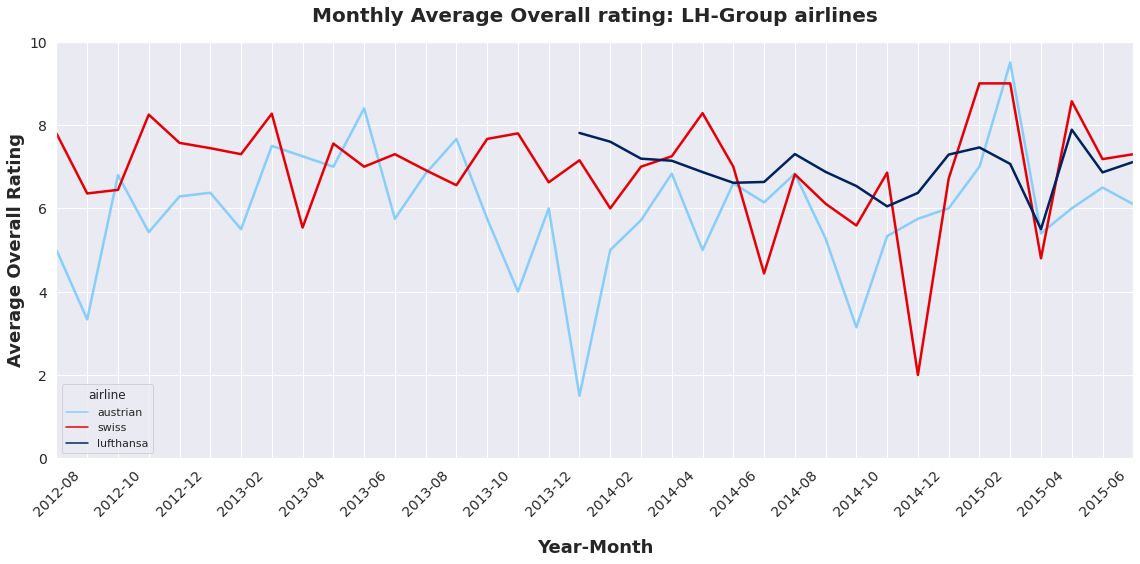

In [41]:
# plot monthly average rating over time for LH-Group airlines

timeFig, timeAx = plt.subplots(1,1, figsize=(16,8))

overallMean = plotSet.copy(deep=True)
overallMean['date'] = overallMean['date'].dt.strftime('%Y-%m')
overallMean = overallMean.groupby(['date', 'airline']).mean()
overallMean = overallMean.loc['2012-06':'2015-07']

timeAx = sns.lineplot(x="date", y="overall_rating", hue="airline", palette=groupPalette, data=overallMean, lw=2.5)

xticks = overallMean.index.get_level_values(0)

#import matplotlib.ticker as ticker
#import matplotlib.dates as mdates
#from matplotlib.dates import DateFormatter

#date_form = DateFormatter('%Y-%M')
timeAx.tick_params(axis='x', rotation=45)


timeAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
timeAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
timeAx.set_title('Monthly Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

timeAx.tick_params(axis='both', which='major', labelsize=14)

timeAx.set_xlim(xticks[2],xticks[-1])
timeAx.set_ylim(0, 10)

# kann man über Locator und Formatter schöner lösen, aber tut hier seinen Zweck
for index, label in enumerate(timeAx.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
timeFig.tight_layout()

## Da Ausreisser den Mittelwert stark beeinflussen, soll der gleitende Durchschnitt über mehrere Monate berechenet werden

In [46]:
#test = reviewTimeline[reviewTimeline['airline']=='austrian']
#test[test['date']=='2011-11'].mean()
monthlyMean = plotSet.copy(deep=True)
monthlyMean['date'] = monthlyMean['date'].dt.strftime('%Y-%m')

In [47]:
monthlyMean = plotSet.copy(deep=True)
monthlyMean['date'] = monthlyMean['date'].dt.strftime('%Y-%m')
#monthlyMean = reviewTimeline.drop(columns={'cabin_flown'})
monthlyMean = monthlyMean.groupby(['airline','date']).mean()
monthlyMean = monthlyMean.reset_index()
monthlyMean = monthlyMean.groupby(['airline']).rolling(3,1, on='date').mean()

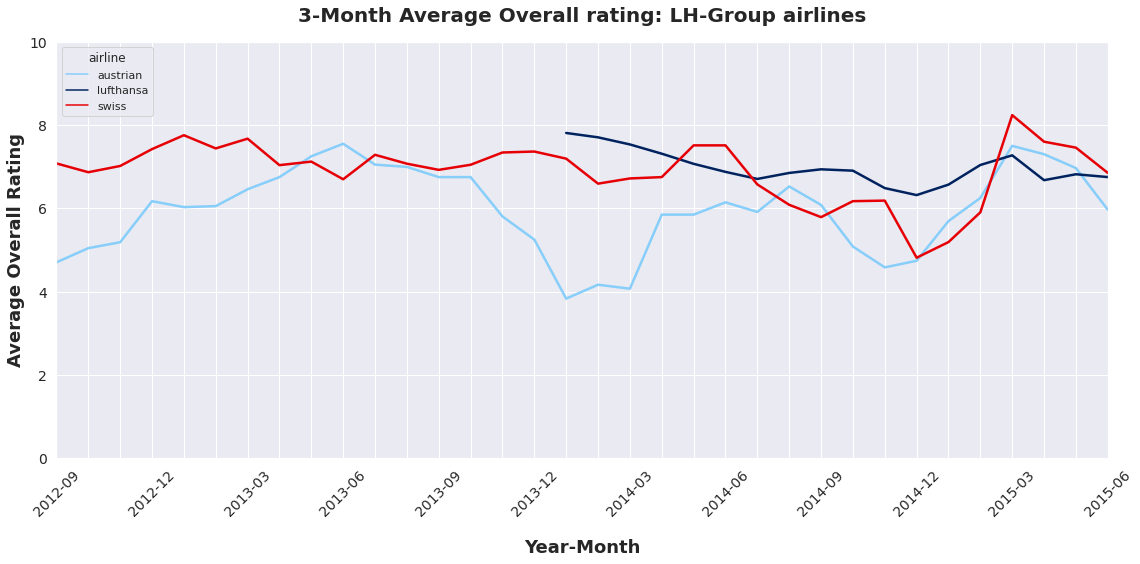

In [48]:
rollingFig, rollingAx = plt.subplots(1,1, figsize=(16,8))

rollingAx = sns.lineplot(x="date", y="overall_rating", hue="airline", palette=groupPalette, data=monthlyMean, lw=2.5)

rollingAx.tick_params(axis='x', rotation=45)


rollingAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
rollingAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
rollingAx.set_title('3-Month Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

rollingAx.tick_params(axis='both', which='major', labelsize=14)

rollingAx.set_xlim(xticks[4],xticks[-5])

#rollingAx.set_xlim('2012-08','2015-06')
rollingAx.set_ylim(0, 10)

# kann man über Locator und Formatter schöner lösen, aber tut hier seinen Zweck
for index, label in enumerate(rollingAx.xaxis.get_ticklabels()):
    if (index+2) % 3 != 0:
        label.set_visible(False)
        
rollingFig.tight_layout()

In [49]:

#len(contentData['austrian-airlines'])

In [50]:
datapointMean = reviewTimeline.drop(columns={'cabin_flown'})
datapointMean = datapointMean.set_index(['airline','date'])
datapointMean.head()

overall_rating  seat_comfort_rating  cabin_staff_rating  \
airline date                                                                  
swiss   2015-07-31             9.0                  5.0                 5.0   
        2015-07-27             9.0                  4.0                 5.0   
        2015-07-25             8.0                  5.0                 4.0   
        2015-07-23             7.0                  4.0                 4.0   
        2015-07-17             1.0                  1.0                 1.0   

                    food_beverages_rating  inflight_entertainment_rating  \
airline date                                                               
swiss   2015-07-31                    5.0                            4.0   
        2015-07-27                    5.0                            3.0   
        2015-07-25                    4.0                            4.0   
        2015-07-23                    4.0                            3.0   
        2015-07-17                    1.0                            1.0   

                    value_money_rating  recommended  
airline date                                         
swiss   2015-07-31                 5.0            1  
        2015-07-27                 5.0            1  
        2015-07-25                 5.0            1  
        2015-07-23                 4.0            1  
        2015-07-17                 1.0            0

In [51]:
datapointMean = reviewTimeline.drop(columns={'cabin_flown'})

#datapointMean = datapointMean.set_index(['Airline','date'])#['overall_rating'].mean()#.mean()#.mean()
#datapointMean = datapointMean.rolling(20).mean()

overallMean = datapointMean.groupby(['airline'])['overall_rating'].rolling(3).mean()#.reset_index(0,drop=True)#.reset_index()#,'date'])
#datapointMean['rolling_overall'] = datapointMean['overall_rating'].rolling(3).mean()
#monthlyMean = monthlyMean.reset_index() #= rollingMean.groupby(['Airline','date']).rolling(3,1).mean()#rolling(window=3)['overall_rating'].mean()
#rollingMean = monthlyMean.groupby(['Airline']).rolling(3,1, on='date').mean()
#datapointMean.head()
datapointMean.reset_index().index

RangeIndex(start=0, stop=1213, step=1)

In [52]:
#overallMean.reset_index().index
datapointMean = reviewTimeline.drop(columns={'cabin_flown'})
date = datapointMean.groupby(['airline'])
#datapointMean = datapointMean.drop(columns={'date'})


ast = datapointMean.groupby(['airline']).rolling(3).mean(numeric_only=True)
#ast = datapointMean.set_index(['Airline'])
#bst = datapointMean.groupby(['Airline'])
#date = datapointMean.groupby(['Airline'])['date']
#datapointMean = datapointMean.drop(columns='date')
date

/tmp/ipykernel_12698/215531708.py:7: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  ast = datapointMean.groupby(['airline']).rolling(3).mean(numeric_only=True)


In [53]:
#test = reviewTimeline[reviewTimeline['Airline']=='Swiss']
#test[test['date']=='2015-03']
#pd.set_option('display.max_rows', None)
#rollingMean.loc['2014-10':]
#pd.set_option('display.max_rows', 20)
testSet = groupSet.copy(deep=True)
testSet['date'] = pd.to_datetime(testSet['date'])

testSet = testSet.drop(columns={'cabin_flown'})
ast = testSet.set_index('date')#.rolling(3).mean()
ast = ast.groupby(['airline']).rolling(2).mean()
ast = ast.reset_index()
ast['date'] = ast['date'].dt.strftime('%Y-%m')
#ast = ast.groupby(['Airline'])

In [54]:
testSet = groupSet.copy(deep=True)
testSet['date'] = pd.to_datetime(testSet['date'])

testSet = testSet.drop(columns={'cabin_flown'})
ast = testSet.set_index('date')#.rolling(3).mean()
ast = ast.groupby(['airline']).rolling(20,1).mean()
ast = ast.reset_index()
ast = ast.sort_values(by='date')
ast['date'] = ast['date'].dt.strftime('%Y-%m')
#ast = ast.loc['2012-06':'2015-07']
#ast['date'] = ast['date'].dt.strftime('%Y-%m')
#ast = ast.groupby(['Airline'])

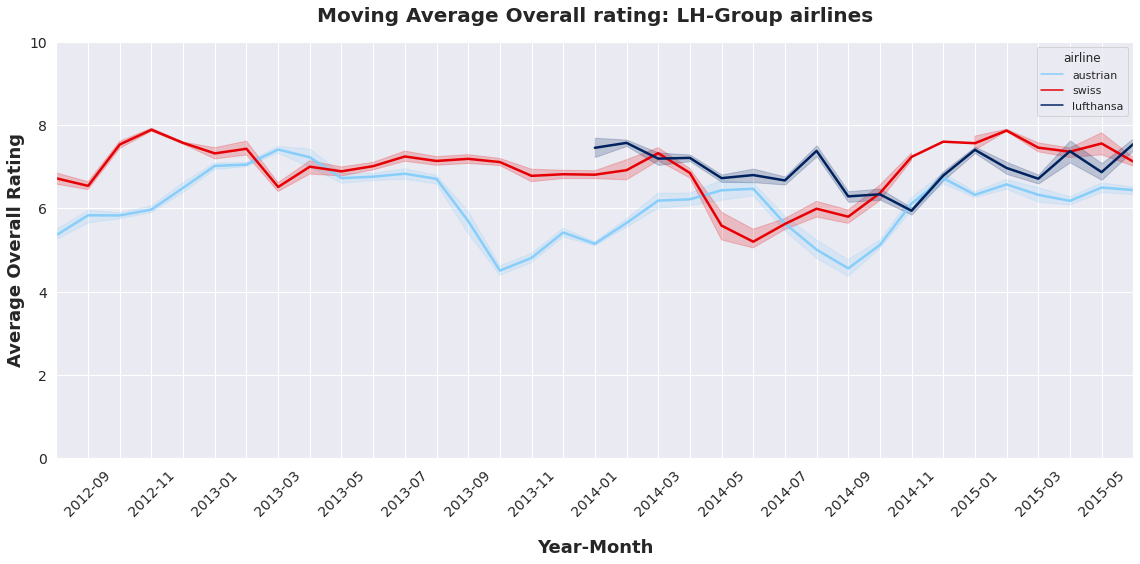

In [55]:
rollingFig, rollingAx = plt.subplots(1,1, figsize=(16,8))

rollingAx = sns.lineplot(x="date", y="overall_rating", hue="airline", palette=groupPalette, data=ast, lw=2.5)

#xticks = ast.index.get_level_values(0)


#date_form = DateFormatter('%Y-%M')
rollingAx.tick_params(axis='x', rotation=45)


rollingAx.set_xlabel('Year-Month', fontsize=18, fontweight='bold', labelpad=20)
rollingAx.set_ylabel('Average Overall Rating', fontsize=18, fontweight='bold')
rollingAx.set_title('Moving Average Overall rating: LH-Group airlines',fontsize=20, fontweight='bold', pad=20)

rollingAx.tick_params(axis='both', which='major', labelsize=14)

rollingAx.set_xlim(xticks[2],xticks[-4])
rollingAx.set_ylim(0, 10)

# kann man über Locator und Formatter schöner lösen, aber tut hier seinen Zweck
for index, label in enumerate(rollingAx.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
        
rollingFig.tight_layout()

## Compare rating between SWISS and other airlines

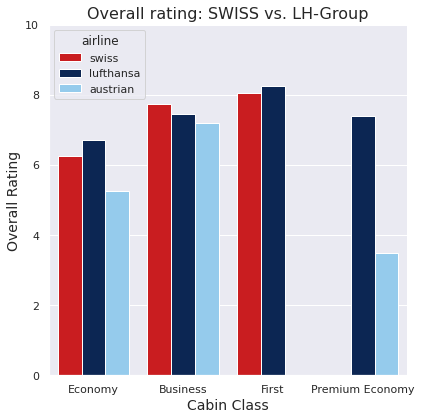

In [57]:
g = sns.catplotg = sns.catplot(
    data=groupSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="airline", palette=groupPalette,
    height=6, ci=None, legend_out=False
)
g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. LH-Group',fontsize=16)
g.ax.set_ylim(0,10)
g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,10)
#g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=legacySet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=legacyPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. Legacy Carrier',fontsize=16)
g.ax.set_ylim(0,10)
#g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=europeSet, kind="bar",
    x="cabin_flown", y="overall_rating", hue="Airline", palette=europePalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Overall Rating', fontsize=14)
g.ax.set_title('Overall rating: SWISS vs. European Carrier',fontsize=16)
g.ax.set_ylim(0,10)
#g.fig.tight_layout()

In [ ]:
# drop data for premium economy, as SWISS did not have a premium eco in 2015

fiveStarSet = fiveStarSet[fiveStarSet.cabin_flown != 'Premium Economy']

In [ ]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="seat_comfort_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Seat comfort', fontsize=14)
g.ax.set_title('Seat comfort: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="cabin_staff_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Cabin staff', fontsize=14)
g.ax.set_title('Cabin staff: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="food_beverages_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Cabin staff', fontsize=14)
g.ax.set_title('Food & Beverages: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="inflight_entertainment_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('IFE Rating', fontsize=14)
g.ax.set_title('IFE rating: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

In [ ]:
g = sns.catplot(
    data=fiveStarSet, kind="bar",
    x="cabin_flown", y="value_money_rating", hue="Airline", palette=fiveStarPalette,
    height=6, ci=None, #legend_out=False
)

g.ax.set_xlabel('Cabin Class', fontsize=14)
g.ax.set_ylabel('Value-money Rating', fontsize=14)
g.ax.set_title('Value-money rating: SWISS vs. 5-Star Airlines',fontsize=16)
g.ax.set_ylim(0,5)
#g.fig.tight_layout()

In [ ]:
sns.barplot(data=lhGroup['swiss'], x="cabin_flown", y="overall_rating")

In [ ]:
swiss = lhGroup['swiss']
sia = fiveStar['sia']
print(sia[sia['cabin_flown']=="Economy"]['overall_rating'].std())
print(swiss[swiss['cabin_flown']=="Economy"]['overall_rating'].std())

In [ ]:
airline = lhGroup['swiss']

fig0, ax0 = plt.subplots(2,3, figsize=(15,10))
fig0.suptitle("Individual ratings vs. overall rating", fontsize=14)
colorMap = {0:neg, 1:pos}
#colorMap = {0:'r', 1:'k'}

xValue = airline['overall_rating']
yValue = [airline['inflight_entertainment_rating'], airline['seat_comfort_rating'], 
          airline['cabin_staff_rating'], airline['food_beverages_rating'],
          airline['value_money_rating'], airline['overall_rating']]

for i in range(2):
    for j in range(3):
        idx = 3*i + j
        
        jittered_y = xValue + 0.2 * np.random.rand(len(xValue)) -0.1
        jittered_x = yValue[idx] + 0.2 * np.random.rand(len(yValue[idx])) -0.1
        
        ax0[i][j].scatter(jittered_y, jittered_x, c=swiss['recommended'].map(colorMap))
        
        ax0[i][j].grid()
        ax0[i][j].set_xlabel("Overall rating")
        ax0[i][j].set_ylabel(yValue[idx].name)

fig0.tight_layout()

In [ ]:
fig0, ax0 = plt.subplots(1,1, figsize=(4,4))

colorMap = {0: neg, 1: pos}

ax0.hist(swiss['overall_rating'])
ax0.grid()
#ax0.legend()

In [ ]:
# Leitfrage: Welcher Faktor beeinflusst die Gesamtbewertung am meisten
df_corr = groupSet.corr()


colormap = plt.cm.Blues

fig17, ax17 = plt.subplots(figsize=(10,5))

fig17.suptitle(u'Crosscorrelation', y=1.05, size=16)

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_corr, mask=mask, linewidths=0.1,vmin= 0, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
# Ideas: perform binary classification on recommendation

In [ ]:
# Multivariate regression on overall rating

## Garbage area

In [ ]:
figRate, axRate = plt.subplots(1,2, figsize=(8,4))
lhGroup['swiss']['overall_rating'].hist(ax=axRate[0])
fiveStar['sia']['overall_rating'].hist(ax=axRate[1])

for i in range(2):
    axRate[i].set_ylim(0, 150)

In [ ]:
airline1 = fiveStar['asiana']
airline2 = lhGroup['swiss']

In [ ]:
pd.crosstab(airline1['cabin_flown'],airline1['recommended'], normalize=False).plot.bar(stacked=True)
pd.crosstab(airline2['cabin_flown'],airline2['recommended'], normalize=False).plot.bar(stacked=True)
# Wie viel Prozent der Reisenden empfehlen Produkt weiter?

In [ ]:
sns.countplot(x=airline2['cabin_flown'])